In [1]:
!pip install ../input/huggingface-transformers/sacremoses-master/sacremoses-master
!pip install ../input/huggingface-transformers/transformers-master/transformers-master

Processing /kaggle/input/huggingface-transformers/sacremoses-master/sacremoses-master
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=882724 sha256=77e89cb21261c559e1ce0fac0c7732c3ab3133079e73768cd84c1232eb33640b
  Stored in directory: /root/.cache/pip/wheels/b3/c1/90/fb74570cc1a23673f29766b39fa295da523fac9813fb3f32c9
Successfully built sacremoses
Processing /kaggle/input/huggingface-transformers/transformers-master/transformers-master
  Created wheel for transformers: filename=transformers-2.2.2-cp36-none-any.whl size=415676 sha256=25a9b36de8f80f259a2f9b6bc22a39898238b077c7de73481bd89cdbf2dff556
  Stored in directory: /root/.cache/pip/wheels/7e/f5/40/5ef4fd8956cee49677c0bdfe569e8aa2cc7f2441e8bef98d1a
Successfully built transformers


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import gc
from sklearn.model_selection import train_test_split, GroupKFold
# import bert_tokenization as tokenization
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import TFPreTrainedModel, TFBertMainLayer, BertConfig, TFBertModel, BertTokenizer
from tqdm import tqdm
tqdm.pandas()
import pyprind 
import warnings
warnings.filterwarnings('ignore')
import operator
import string
import json
import re
import gensim
from gensim.models import KeyedVectors
import seaborn as sns
import time
import random
import pickle
import joblib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import operator
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from spacy.lang.en import English
import re
from keras.preprocessing import text
# from tqdm import tqdm, tqdm_notebook
# tqdm_notebook().pandas()
import bert_tokenization as tokenization

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_2.hdf5
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_1.hdf5
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_4.hdf5
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_3.hdf5
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert-base-1-4.hdf5
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert-base-2-4.hdf5
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_0.hdf5
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert-base-0-4.hdf5
/kaggle/input/google-quest-challenge/train.csv
/kaggle/input/google-quest-challenge/test.csv
/kaggle/input/google-quest-challenge/sample_submission.csv
/kaggle/input/huggingface-transformers/sacremoses-master/sacremoses-master/README.md
/kaggle/input/huggingface-transformers/sacremoses-master/sacremoses-master/CONTRIBUTORS.md
/

Using TensorFlow backend.


In [3]:
PATH = '../input/google-quest-challenge/'

BERT_PATH = '../input/bert-base-from-tfhub/bert_en_uncased_L-12_H-768_A-12'
tokenizer_google_qa = tokenization.FullTokenizer(BERT_PATH+'/assets/vocab.txt', True)
tokenizer2 = BertTokenizer.from_pretrained(BERT_PATH+'/assets/vocab.txt', do_lower_case=True,)
MAX_SEQUENCE_LENGTH = 512

df_train = pd.read_csv(PATH+'train.csv',header=0,encoding='utf-8')
df_test = pd.read_csv(PATH+'test.csv',header=0,encoding='utf-8')
df_sub = pd.read_csv(PATH+'sample_submission.csv')
df = pd.concat([df_train,df_test],axis=0,ignore_index=True)
print(f'''Train Shape: {df_train.shape}
Test Shape: {df_test.shape}
Df Shape:{df.shape}''')

output_categories = ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']
input_categories = ['question_title', 'question_body', 'answer']
print('\noutput categories:\n\t', output_categories)
print('\ninput categories:\n\t', input_categories)

Train Shape: (6079, 41)
Test Shape: (476, 11)
Df Shape:(6555, 41)

output categories:
	 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']

input categories:
	 ['question_title', 'question_body', 'answer']


In [4]:
# def get_wordnet_pos(treebank_tag):
#     """
#     return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
#     """
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         # As default pos in lemmatization is Noun
#         return wordnet.NOUN

In [5]:
tree_tokenizer = TreebankWordTokenizer()
# wnl = WordNetLemmatizer()
def get_tree_tokens(x):
    x = tree_tokenizer.tokenize(x)
#     pos_tokens = [nltk.pos_tag(x)]
#     l=[]
#     for pos in pos_tokens: 
#         for word, tag in pos:
#             l.append(wnl.lemmatize(word,get_wordnet_pos(tag)))
    
    x = ' '.join(x)
    return x

In [6]:
for col in input_categories:
    df_train[f'treated_{col}'] = df_train[col].progress_apply(lambda x: get_tree_tokens(x))
    df_test[f'treated_{col}'] = df_test[col].progress_apply(lambda x: get_tree_tokens(x))
    df[f'treated_{col}'] = df[col].progress_apply(lambda x: get_tree_tokens(x))

100%|██████████| 6555/6555 [00:09<00:00, 726.05it/s]


In [7]:
tokenizer = text.Tokenizer(lower=False)

In [8]:
X_train_question = df_train['question_body']
X_train_title    = df_train['question_title']
X_train_answer   = df_train['answer']

X_test_question  = df_test['question_body']
X_test_title     = df_test['question_title']
X_test_answer    = df_test['answer']

In [9]:
tokenizer.fit_on_texts(list(X_train_title)+list(X_train_question)+list(X_train_answer)+list(X_test_title)+list(X_test_question)+list(X_test_answer))

In [10]:
nlp = English()
sentencizer = nlp.create_pipe('sentencizer')
nlp.add_pipe(sentencizer)

In [11]:
def split_document(texts):
    all_sents = []
    max_num_sentences = 0.0
    for text in texts:
        doc = nlp(text)
#         print('Sents',doc.sents)
        sents=[]
        for i,sent in enumerate(doc.sents):
            sents.append(sent.text)
        all_sents.append(sents)
    
    return all_sents
        
X_train_question = split_document(X_train_question)
# X_train_title = split_document(X_train_title)
X_train_answer = split_document(X_train_answer)

X_test_question = split_document(X_test_question)
X_test_answer = split_document(X_test_answer)



In [12]:
def add_question_metadata_features(text):
    doc=nlp(text)
    indirect = 0
    choice_words=0
    reason_explanation_words = 0
    question_count = 0
    
    for sent in doc.sents:
        if '?' in sent.text and '?' == sent.text[-1]:
            question_count += 1
            for token in sent:
                if token.text.lower()=='why':
                    reason_explanation_words+=1
                elif token.text.lower()=='or':
                    choice_words+=1
    if question_count==0:
        indirect+=1
    
    return np.array([indirect, question_count, reason_explanation_words, choice_words])

In [13]:
ans_user_and_category=df_train[df_train[['answer_user_name', 'category']].duplicated()][['answer_user_name', 'category']].values
ans_user_and_category.shape

(1752, 2)

In [14]:
def question_answer_author_same(df):
    q_username = df['question_user_name']
    a_username = df['answer_user_name']
    author_same=[]
    
    for i in range(len(df)):
        if q_username[i] == a_username[i]:
            author_same.append(int(1))
        else:
            author_same.append(int(0))
    return author_same
        

In [15]:
def add_external_features(df):
    df['question_body'] = df['question_body'].progress_apply(lambda x: str(x))
    df['question_body_num_words'] = df['question_body'].str.count('\S+')
    
    df['answer'] = df['answer'].progress_apply(lambda x: str(x))
    df['answer_num_words'] = df['answer'].str.count('\S+')
    
    df['question_vs_answer_length'] = df['question_body_num_words']/df['answer_num_words']
    
    df['q_a_author_same'] = question_answer_author_same(df)
    
    answer_user_cat = []
    for i in tqdm(df[['answer_user_name', 'category']].values):
        if i in ans_user_and_category:
            answer_user_cat.append(int(1))
        else:
            answer_user_cat.append(int(0))
    df['answer_user_cat'] = answer_user_cat
    
    handmade_features=[]
    for text in df['question_body'].values:
        handmade_features.append(add_question_metadata_features(text))

    
    return df, np.array(handmade_features)
        

In [16]:
df_train, handmade_features = add_external_features(df_train)
df_test, handmade_features_test = add_external_features(df_test)

df_train = pd.concat([df_train,pd.DataFrame(handmade_features, columns=['indirect', 'question_count', 'reason_explanation_words', 'choice_words'])],axis=1)
df_test = pd.concat([df_test,pd.DataFrame(handmade_features_test, columns=['indirect', 'question_count', 'reason_explanation_words', 'choice_words'])],axis=1)

100%|██████████| 476/476 [00:00<00:00, 5313.15it/s]


In [17]:
df_train.shape, df_test.shape

((6079, 53), (476, 23))

In [18]:
num_words_scaler = MinMaxScaler()
df_train[['question_body_num_words', 'answer_num_words']] = num_words_scaler.fit_transform(df_train[['question_body_num_words', 'answer_num_words']].values)
df_test[['question_body_num_words', 'answer_num_words']] = num_words_scaler.transform(df_test[['question_body_num_words', 'answer_num_words']].values)

In [19]:
# unique_categories = list(set(df_train['category'].unique().tolist() + df_test['category'].unique().tolist()))
# category_dict = {i + 1: e for i, e in enumerate(unique_categories)}
# category_dict_reverse = {v: k for k, v in category_dict.items()}

In [20]:
# le_cat = LabelEncoder()
# df_train['category']=le_cat.fit_transform(df_train['category'])
# df_test['category']=le_cat.transform(df_test['category'])

In [21]:
# le_host = LabelEncoder()
# le_host.fit(list(set(df_train['host'].values.tolist()+df_test['host'].values.tolist())))
# df_train['host']=le_host.transform(df_train['host'])
# df_test['host']=le_host.transform(df_test['host'])

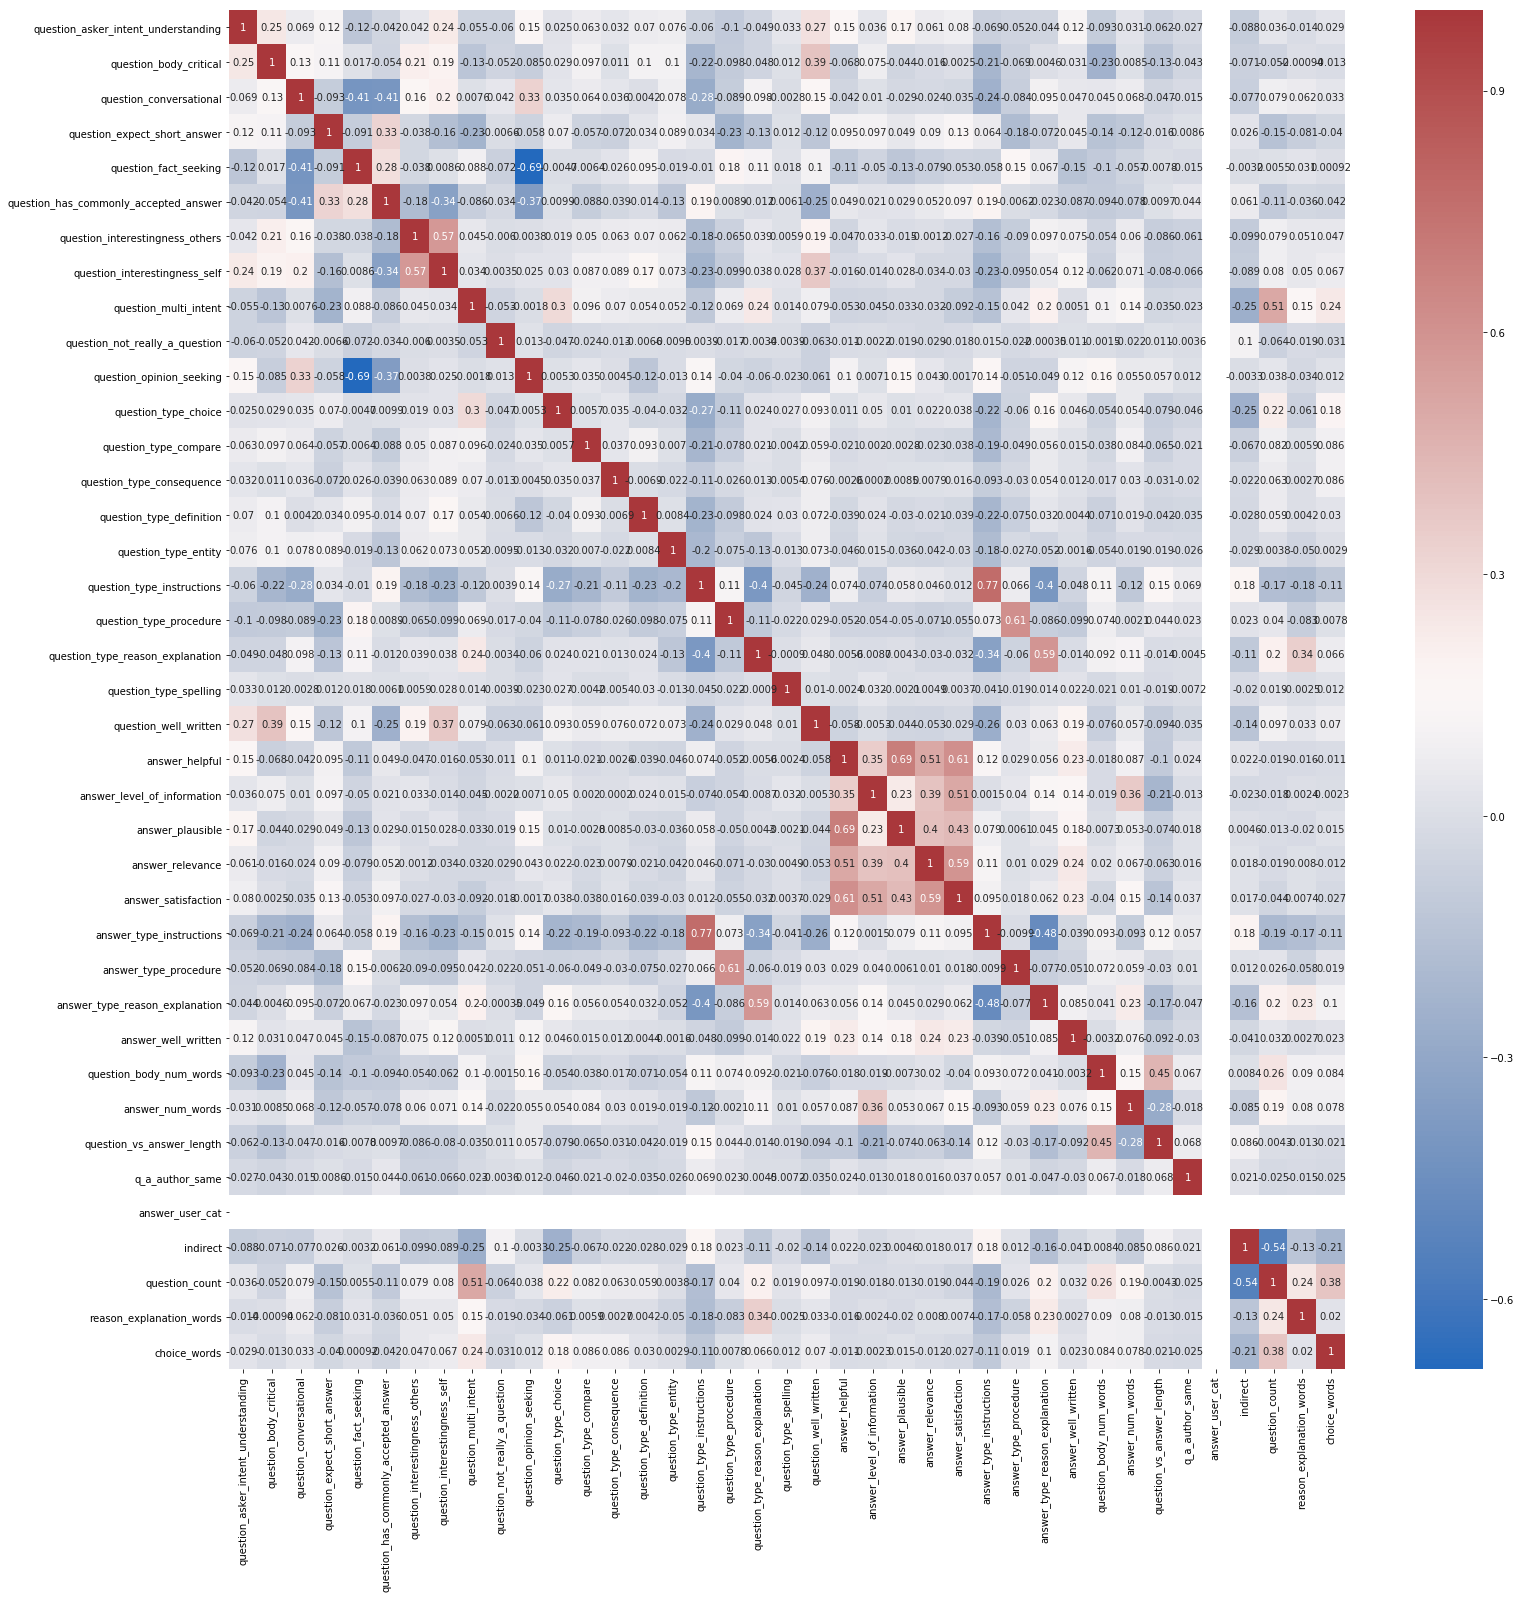

In [22]:
from scipy.spatial.distance import cdist
cols = output_categories+['question_body_num_words',
       'answer_num_words', 'question_vs_answer_length', 'q_a_author_same',
       'answer_user_cat', 'indirect', 'question_count',
       'reason_explanation_words', 'choice_words']
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(df_train[cols].corr() , ax=ax, annot=True, cmap='vlag')

In [23]:
df_train.shape, df_test.shape

((6079, 53), (476, 23))

In [24]:
df=pd.concat([df,pd.get_dummies(df['host'], drop_first=False, prefix='host')],axis=1)
df=pd.concat([df,pd.get_dummies(df['category'], drop_first=False, prefix='cat')],axis=1)

In [25]:
len(['qa_id']+[i for i in df.columns if i.startswith('host_') or i.startswith('cat_')])

70

In [26]:
df_train=pd.merge(df_train, df[['qa_id']+[i for i in df.columns if i.startswith('host_') or i.startswith('cat_')]], how='inner', on='qa_id')
df_test = pd.merge(df_test, df[['qa_id']+[i for i in df.columns if i.startswith('host_') or i.startswith('cat_')]], how='inner', on='qa_id')

In [27]:
# df_train=pd.concat([df_train,pd.get_dummies(df_train['host'], drop_first=False, prefix='host')],axis=1)
# df_train=pd.concat([df_train,pd.get_dummies(df_train['category'], drop_first=False, prefix='cat')],axis=1)

In [28]:
# df_test=pd.concat([df_test,pd.get_dummies(df_test['host'], drop_first=False, prefix='host')],axis=1)
# df_test=pd.concat([df_test,pd.get_dummies(df_test['category'], drop_first=False, prefix='cat')],axis=1)

In [29]:
df_train.shape, df_test.shape

((6079, 122), (476, 92))

In [30]:
df_train.drop(['host', 'category'], inplace=True, axis=1)
df_test.drop(['host', 'category'], inplace=True, axis=1)

In [31]:
def _get_masks(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens)+[0]*(max_seq_length-len(tokens))

def _get_segments(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    
    segments=[]
    first_sep=True
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == '[SEP]':
#             if first_sep:
#                 first_sep=False
#             else:
            current_segment_id=1
    return segments+[0]*(max_seq_length-len(tokens))

def _trim_input_questions(title, question, max_sequence_length, t_max_len=30, q_max_len=479):

    t = tokenizer2.tokenize(title)
    q = tokenizer2.tokenize(question)
#     a = tokenizer2.tokenize(answer)
    
    t_len = len(t)
    q_len = len(q)
    #a_len = len(a)

    if (t_len+q_len+3) > max_sequence_length:
        
        if t_max_len > t_len:
            t_new_len = t_len
            #a_max_len = a_max_len + floor((t_max_len - t_len)/2)
            q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        else:
            t_new_len = t_max_len
      
        #if a_max_len > a_len:
        #    a_new_len = a_len 
        #    q_new_len = q_max_len + (a_max_len - a_len)
        if q_max_len > q_len:
        #    a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
        #    a_new_len = a_max_len
            q_new_len = q_max_len
            
            
        if t_new_len+q_new_len+3 > max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length, (t_new_len+q_new_len+3)))
        
        t = t[:t_new_len]
        q = q[:q_new_len]
        #a = a[:a_new_len]
    
    return t, q
    
def _get_ids(tokens, tokenizer, max_seq_length):
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0]*(max_seq_length - len(token_ids))
    return input_ids
    
    
def _convert_to_bert_inputs_questions(title, question,tokenizer, max_seq_length):
    stoken = ['[CLS]']+title+['[SEP]']+question+['[SEP]']#+answer+['[SEP]']
    input_ids = _get_ids(tokens=stoken, tokenizer=tokenizer,max_seq_length=max_seq_length)
    input_masks = _get_masks(tokens=stoken, max_seq_length=max_seq_length)
    input_segments = _get_segments(tokens=stoken, max_seq_length=max_seq_length)
    return [input_ids, input_masks, input_segments]
    
    
def compute_input_array_questions(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for _, col in tqdm(df[columns].iterrows()):
        t, q = col['treated_question_title'], col['treated_question_body']
        
        t,q = _trim_input_questions(t,q, max_sequence_length)
        
        ids, masks, segments = _convert_to_bert_inputs_questions(t,q, tokenizer, max_sequence_length)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.array(input_ids, dtype=np.int32), np.array(input_masks, dtype=np.int32), 
            np.array(input_segments, dtype=np.int32)]


def _trim_input_answers(answer, max_sequence_length, a_max_len=510):

    #t = tokenizer2.tokenize(title)
    #q = tokenizer2.tokenize(question)
    a = tokenizer2.tokenize(answer)
    
    #t_len = len(t)
    #q_len = len(q)
    a_len = len(a)

    if (a_len+2) > max_sequence_length:
        
        #if t_max_len > t_len:
        #    t_new_len = t_len
        #    a_max_len = a_max_len + floor((t_max_len - t_len)/2)
        #    q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        #else:
        #    t_new_len = t_max_len
      
        if a_max_len > a_len:
            a_new_len = a_len 
        #    q_new_len = q_max_len + (a_max_len - a_len)
        #elif q_max_len > q_len:
        #    a_new_len = a_max_len + (q_max_len - q_len)
        #    q_new_len = q_len
        else:
            a_new_len = a_max_len
        #    q_new_len = q_max_len
            
            
        if a_new_len+2 > max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length, (a_new_len+2)))
        
        #t = t[:t_new_len]
        #q = q[:q_new_len]
        a = a[:a_new_len]
    
    return a
    
    
    
def _convert_to_bert_inputs_answers(answer, tokenizer, max_seq_length):
    stoken = ['[CLS]']+answer+['[SEP]']
    input_ids = _get_ids(tokens=stoken, tokenizer=tokenizer,max_seq_length=max_seq_length)
    input_masks = _get_masks(tokens=stoken, max_seq_length=max_seq_length)
    input_segments = _get_segments(tokens=stoken, max_seq_length=max_seq_length)
    return [input_ids, input_masks, input_segments]
    
    
def compute_input_array_answers(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for _, col in tqdm(df[columns].iterrows()):
        a = col['treated_answer']
        a = _trim_input_answers(a, max_sequence_length)
        ids, masks, segments = _convert_to_bert_inputs_answers(a, tokenizer, max_sequence_length)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.array(input_ids, dtype=np.int32), np.array(input_masks, dtype=np.int32), 
            np.array(input_segments, dtype=np.int32)]   

def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

def compute_spearmanr(trues, preds):
    rhos=[]
    for t, p in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(t,p).correlation
        )
    return np.nanmean(rhos)

# test_predictions=[]

class CustomCallback(keras.callbacks.Callback):
    def __init__(self, valid_data, test_data, test_predictions=test_predictions, batch_size=16, fold=None):
        self.valid_inputs = valid_data[0]
        self.valid_outputs = valid_data[1]
        self.test_inputs = test_data
        self.batch_size = batch_size
        self.test_predictions = test_predictions
        self.fold = fold
        
    def on_train_begin(self, logs={}):
        self.valid_predictions=[]
        #self.test_predictions=[]
        
    def on_epoch_end(self, epoch, logs={}):
        self.valid_predictions.append(self.model.predict(self.valid_inputs, batch_size=self.batch_size))
        
        rho_val = compute_spearmanr(self.valid_outputs, np.average(self.valid_predictions, axis=0))
        print(f"\nvalidation rho: {round(rho_val,4)}")
        
#         if (epoch+1)%4==0:
#             self.model.save_weights(f'/kaggle/working/bert-base-{fold}-{epoch}.hdf5')
            
        self.test_predictions.append(self.model.predict(self.test_inputs, batch_size=self.batch_size))

NameError: name 'test_predictions' is not defined

In [32]:
bert_config=BertConfig(unk_token="[QBODY]", pad_token="[ANS]").from_pretrained('../input/bert-tensorflow/bert-base-uncased-config.json',output_hidden_states=True)
def bertModel():
    input_ids_q = keras.layers.Input((MAX_SEQUENCE_LENGTH), dtype = tf.int32, name = 'input_word_ids_q')
    input_mask_q = keras.layers.Input((MAX_SEQUENCE_LENGTH), dtype = tf.int32, name = 'input_masks_q')
    input_segments_q = keras.layers.Input((MAX_SEQUENCE_LENGTH), dtype = tf.int32, name = 'input_segments_q')
#     input_categories = keras.layers.Input((len([i for i in df.columns if i.startswith('host_') or i.startswith('cat_')])),dtype=tf.float32, name='input_categorical')
    input_new_features = keras.layers.Input((9,), dtype=tf.float32, name='input_new_features')
    
    input_ids_a = keras.layers.Input((MAX_SEQUENCE_LENGTH), dtype = tf.int32, name = 'input_word_ids_a')
    input_mask_a = keras.layers.Input((MAX_SEQUENCE_LENGTH), dtype = tf.int32, name = 'input_masks_a')
    input_segments_a = keras.layers.Input((MAX_SEQUENCE_LENGTH), dtype = tf.int32, name = 'input_segments_a')
    
    
    bert_model_q = TFBertModel.from_pretrained(pretrained_model_name_or_path='../input/bert-tensorflow/bert-base-uncased-tf_model.h5',config = bert_config)
    
    bert_model_a = TFBertModel.from_pretrained(pretrained_model_name_or_path='../input/bert-tensorflow/bert-base-uncased-tf_model.h5',config = bert_config)
#     bert_model.resize_token_embeddings(len(tokenizer2))
    _, _, hidden_states_q = bert_model_q([input_ids_q,input_mask_q, input_segments_a])
    _, _, hidden_states_a = bert_model_a([input_ids_a,input_mask_a, input_segments_a])
    
    h12_q = tf.reshape(hidden_states_q[-1][:,0],(-1,1,768))
    h11_q = tf.reshape(hidden_states_q[-2][:,0],(-1,1,768))
    h10_q = tf.reshape(hidden_states_q[-3][:,0],(-1,1,768))
    h09_q = tf.reshape(hidden_states_q[-4][:,0],(-1,1,768))
    concat_hidden_q = keras.layers.Concatenate(axis=2)([h12_q, h11_q, h10_q, h09_q])
    
    h12_a = tf.reshape(hidden_states_a[-1][:,0],(-1,1,768))
    h11_a = tf.reshape(hidden_states_a[-2][:,0],(-1,1,768))
    h10_a = tf.reshape(hidden_states_a[-3][:,0],(-1,1,768))
    h09_a = tf.reshape(hidden_states_a[-4][:,0],(-1,1,768))
    concat_hidden_a = keras.layers.Concatenate(axis=2)([h12_a, h11_a, h10_a, h09_a])

    x = keras.layers.GlobalAveragePooling1D()(concat_hidden_q)
    x_a = keras.layers.GlobalAveragePooling1D()(concat_hidden_a)
    
    x = keras.layers.Concatenate()([x, input_new_features])#, input_categories])
    x_a = keras.layers.Concatenate()([x_a,x, input_new_features])#, input_categories])
#     dense1 = keras.layers.Dense(768)(x)
#     dense1 = keras.layers.LeakyReLU()(dense1)
#     x = keras.layers.Add()([dense1,x])    
#     x = keras.layers.Dropout(0.2)(x)
#     x_a = keras.layers.Dropout(0.2)(x_a)
    
    out = keras.layers.Dense(len([i for i in output_categories if i.startswith('question')]), activation='sigmoid', name='final_dense_output_q')(x)
    out_a = keras.layers.Dense(len([i for i in output_categories if i.startswith('answer')]), activation='sigmoid', name='final_dense_output_a')(x_a)
    out = keras.layers.Concatenate()([out,out_a])
    
    model = keras.models.Model(inputs=[input_ids_q, input_mask_q, input_segments_q,#input_categories, 
                                       input_new_features, input_ids_a, input_mask_a, input_segments_a]
                               , outputs=out)
    model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(lr=3e-5))
    return model

In [33]:
# model = bertModel()
# model.summary()

In [34]:
gkf = GroupKFold(n_splits=10).split(X=df_train.question_body, groups=df_train.question_body)

In [35]:
# outputs_q = compute_output_arrays(df_train, [i for i in output_categories if i.startswith('question')])
# outputs_a = compute_output_arrays(df_train, [i for i in output_categories if i.startswith('answer')])
outputs = compute_output_arrays(df_train, output_categories)
inputs_q = compute_input_array_questions(df_train, ['treated_question_title','treated_question_body'], tokenizer2, MAX_SEQUENCE_LENGTH)
inputs_a = compute_input_array_answers(df_train, ['treated_answer'], tokenizer2, MAX_SEQUENCE_LENGTH)
test_inputs_q = compute_input_array_questions(df_test, ['treated_question_title','treated_question_body'], tokenizer2, MAX_SEQUENCE_LENGTH)
test_inputs_a = compute_input_array_answers(df_test, ['treated_answer'], tokenizer2, MAX_SEQUENCE_LENGTH)

6079it [00:46, 130.27it/s]
6079it [00:43, 140.87it/s]
476it [00:03, 126.39it/s]
476it [00:03, 137.83it/s]


In [36]:
test_predictions=[]
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    if fold<5:
        keras.backend.clear_session()
        model = bertModel()
        print(f'/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_{fold}.hdf5')
        model.load_weights(f'/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_{fold}.hdf5')
        preds = model.predict(test_inputs_q + #[df_test[[i for i in df.columns if i.startswith('host_') or i.startswith('cat_')]].values]+
                                                     [df_test[['question_body_num_words', 'answer_num_words','question_vs_answer_length', 'q_a_author_same', 'answer_user_cat','indirect', 'question_count', 'reason_explanation_words','choice_words']].values]+test_inputs_a,
                                 batch_size=8, verbose=1)
        test_predictions.append(preds)
        print(f'Fold:{fold} Completed')

/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_0.hdf5
476/476 [==============================] - 28s 59ms/sample
Fold:0 Completed
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_1.hdf5
476/476 [==============================] - 28s 60ms/sample
Fold:1 Completed
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_2.hdf5
476/476 [==============================] - 28s 59ms/sample
Fold:2 Completed
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_3.hdf5
476/476 [==============================] - 28s 59ms/sample
Fold:3 Completed
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert_base_fold_4.hdf5
476/476 [==============================] - 28s 59ms/sample
Fold:4 Completed


In [37]:
# histories = []

# for fold, (train_idx, valid_idx) in enumerate(gkf):
    
#     if fold<4:
#         pass
#     elif fold==4:
#         keras.backend.clear_session()
#         model = bertModel()        
        
#         train_inputs_q = [inputs_q[i][train_idx] for i in range(3)] #+[df_train[[i for i in df_train.columns if i.startswith('cat_') or i.startswith('host_')]].iloc[train_idx,:].values]+[df_train[['question_body_num_words', 'answer_num_words','question_vs_answer_length', 'q_a_author_same', 'answer_user_cat','indirect', 'question_count', 'reason_explanation_words','choice_words']].iloc[train_idx,:].values]
#         train_inputs_a = [inputs_a[i][train_idx] for i in range(3)]
#         train_outputs = outputs[train_idx]
    
#         valid_inputs_q = [inputs_q[i][valid_idx] for i in range(3)]
#         valid_inputs_a = [inputs_a[i][valid_idx] for i in range(3)]
#         valid_outputs = outputs[valid_idx]
    
#         custom_callback = CustomCallback(valid_data=(valid_inputs_q + #[df_train[[i for i in df.columns if i.startswith('host_') or i.startswith('cat_')]].iloc[valid_idx,:].values]+
#                                                       [df_train[['question_body_num_words', 'answer_num_words','question_vs_answer_length', 'q_a_author_same', 'answer_user_cat','indirect', 'question_count', 'reason_explanation_words','choice_words']].iloc[valid_idx,:].values]+ valid_inputs_a,
#                                                       valid_outputs), 
#                                          test_data=test_inputs_q + #[df_test[[i for i in df.columns if i.startswith('host_') or i.startswith('cat_')]].values]+
#                                                     [df_test[['question_body_num_words', 'answer_num_words','question_vs_answer_length', 'q_a_author_same', 'answer_user_cat','indirect', 'question_count', 'reason_explanation_words','choice_words']].values]+test_inputs_a,
#                                          batch_size=8, fold=fold)
#         H = model.fit(train_inputs_q+ 
#                        #[df_train[[i for i in df.columns if i.startswith('host_') or i.startswith('cat_')]].iloc[train_idx,:].values]+ 
#                        [df_train[['question_body_num_words', 'answer_num_words','question_vs_answer_length', 'q_a_author_same', 'answer_user_cat','indirect', 'question_count', 'reason_explanation_words','choice_words']].iloc[train_idx,:].values] + train_inputs_a,
#                       train_outputs, batch_size=4, epochs=4, callbacks=[custom_callback])
#         histories.append(H)
#         model.save_weights(f'/kaggle/working/bert_base_fold_{fold}.hdf5')

In [38]:
#sssddfgdfgfsdfsddfsdfsewefsdsdfghgfefsd

In [39]:
print(len(test_predictions))

5


In [40]:
test_preds = [test_predictions[i] for i in range(len(test_predictions))]
test_preds = [np.average(test_preds[i], axis=0) for i in range(len(test_preds))]
test_preds = np.mean(test_predictions, axis=0)

# df_sub.iloc[:, 1:] = test_preds

# df_sub.to_csv('submission.csv', index=False)

In [41]:
def _get_masks_google_qa(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_segments_google_qa(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    first_sep = True
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            if first_sep:
                first_sep = False 
            else:
                current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def _get_ids_google_qa(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def _trim_input_google_qa(title, question, answer, max_sequence_length, 
                t_max_len=60, q_max_len=224, a_max_len=224):

    t = tokenizer_google_qa.tokenize(title)
    q = tokenizer_google_qa.tokenize(question)
    a = tokenizer_google_qa.tokenize(answer)
    
    t_len = len(t)
    q_len = len(q)
    a_len = len(a)

    if (t_len+q_len+a_len+4) > max_sequence_length:
        
        if t_max_len > t_len:
            t_new_len = t_len
            a_max_len = a_max_len + floor((t_max_len - t_len)/2)
            q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        else:
            t_new_len = t_max_len
      
        if a_max_len > a_len:
            a_new_len = a_len 
            q_new_len = q_max_len + (a_max_len - a_len)
        elif q_max_len > q_len:
            a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
            a_new_len = a_max_len
            q_new_len = q_max_len
            
            
        if t_new_len+a_new_len+q_new_len+4 != max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length, (t_new_len+a_new_len+q_new_len+4)))
        
        t = t[:t_new_len]
        q = q[:q_new_len]
        a = a[:a_new_len]
    
    return t, q, a

def _convert_to_bert_inputs_google_qa(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for BERT"""
    
    stoken = ["[CLS]"] + title + ["[SEP]"] + question + ["[SEP]"] + answer + ["[SEP]"]

    input_ids = _get_ids_google_qa(stoken, tokenizer, max_sequence_length)
    input_masks = _get_masks_google_qa(stoken, max_sequence_length)
    input_segments = _get_segments_google_qa(stoken, max_sequence_length)

    return [input_ids, input_masks, input_segments]

def compute_input_arays_google_qa(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for _, instance in tqdm(df[columns].iterrows()):
        t, q, a = instance['treated_question_title'], instance['treated_question_body'], instance['treated_answer']

        t, q, a = _trim_input_google_qa(t, q, a, max_sequence_length)

        ids, masks, segments = _convert_to_bert_inputs_google_qa(t, q, a, tokenizer, max_sequence_length)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)
           ]


def compute_output_arrays_google_qa(df, columns):
    return np.asarray(df[columns])
def bert_model_google_qa(learning_rate=4e-5,loss_function='binary_crossentropy'):
    
    input_word_ids = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
    input_masks = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
    input_segments = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')
        
    bert_layer = hub.KerasLayer(BERT_PATH, trainable=True)
    
    _, sequence_output = bert_layer([input_word_ids, input_masks, input_segments])
    
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
    out = tf.keras.layers.Dense(30, activation="sigmoid", name="dense_output")(x)
    
    model = tf.keras.models.Model(
        inputs=[[input_word_ids, input_masks, input_segments]], outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss_function, optimizer=optimizer)
    return model    


In [42]:
gkf_google_qa = GroupKFold(n_splits=10).split(X=df_train.question_body, groups=df_train.question_body)
outputs_google_qa = compute_output_arrays_google_qa(df_train, output_categories)
inputs_google_qa = compute_input_arays_google_qa(df_train, ['treated_question_title','treated_question_body','treated_answer'], tokenizer_google_qa, MAX_SEQUENCE_LENGTH)
test_inputs_google_qa = compute_input_arays_google_qa(df_test, ['treated_question_title','treated_question_body','treated_answer'],tokenizer_google_qa, MAX_SEQUENCE_LENGTH)
# histories = []


6079it [01:09, 87.86it/s]
476it [00:05, 85.48it/s]


In [43]:
test_predictions_google_qa=[]
for fold, (train_idx, valid_idx) in enumerate(gkf_google_qa):
    
    if fold<3:
        keras.backend.clear_session()
        model_qa = bert_model_google_qa()
        print(f'/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert-base-{fold}-4.hdf5')
        model_qa.load_weights(f'/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert-base-{fold}-4.hdf5')
        preds_qa = model_qa.predict(test_inputs_google_qa , batch_size=8, verbose=1)
        test_predictions_google_qa.append(preds_qa)
        print(f'Fold:{fold} Completed')

/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert-base-0-4.hdf5
476/476 [==============================] - 12s 26ms/sample
Fold:0 Completed
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert-base-1-4.hdf5
476/476 [==============================] - 14s 29ms/sample
Fold:1 Completed
/kaggle/input/google-qa-bert-trained-tfbert-hiddenl-preprocess/bert-base-2-4.hdf5
476/476 [==============================] - 13s 26ms/sample
Fold:2 Completed


In [44]:
len(test_predictions_google_qa)


3

In [45]:
test_preds_google_qa = [test_predictions_google_qa[i] for i in range(len(test_predictions_google_qa))]
test_preds_google_qa = [np.average(test_preds_google_qa, axis=0) for i in range(len(test_preds_google_qa))]
test_preds_google_qa = np.mean(test_preds_google_qa, axis=0)
test_preds_google_qa.shape

(476, 30)

In [46]:
final_preds = np.average(np.array([test_preds, test_preds_google_qa]),axis=0)
final_preds.shape

(476, 30)

In [47]:
df_sub.iloc[:, 1:] = final_preds

df_sub.to_csv('submission.csv', index=False)